### Setup

In [3]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import nltk
from nltk.tokenize import word_tokenize

from ipywidgets import interact, widgets
from IPython.display import display

from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [4]:
# Anzeigeeinstellungen für Pandas
pd.set_option('display.max_colwidth', 200)

##### Data Set:

The dataset contains five main files: 

- patient_notes.csv (full free-text content of clinical patient notes)
- features.csv (defines the specific medical concepts which need to be identified and evaluated within the patient notes)
- train.csv (Ground-truth annotations, detailing the text span which correspondends with medical feature)
- test.csv 
- sample_submission.csv. (template)

There are 10 total clinical cases, and the patient_notes.csv file contains approximately 40,000 patient notes. 
The primary goal is to identify and extract relevant medical concepts from these free-text notes. 


### Provided Files  

##### Features: A clinically relevant concept. A rubric describes the key concepts relevant to each case.

In [5]:
features_df = pd.read_csv("nbme-score-clinical-patient-notes/features.csv")
features_df.head()

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myocardial-infarction
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded


##### Patient Note: Text detailing important information related by the patient during the encounter (physical exam and interview).

In [6]:
notes_df = pd.read_csv("nbme-score-clinical-patient-notes/patient_notes.csv")
notes_df.head()

,pn_num,case_num,pn_history
0,0,0,"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began ..."
1,1,0,"17 yo male with recurrent palpitations for the past 3 mo lasting about 3 - 4 min, it happened about 5 - 6 times since the beginning. One time durign a baskeball game two days ago light headedness,..."
2,2,0,Dillon Cleveland is a 17 y.o. male patient with no significant PMH who presents with complaints of heart pounding. This has been going on for a few months and happens once or twice a month. He can...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \r\nNOTHING IMPROVES OR EXACERBATES THE SYMPTOMS ACCORDING TO HIM; IT CAN HAPPEN ANY TIME; MAY TAKE A FEW MINUTES; LAST TIME HAPPENED 2 DAYS AGO DURING...
4,4,0,"17yo male with no pmh here for evaluation of palpitations. States for the last 3-4mo he has felt that his heart with intermittently ""beat out of his chest,"" with some associated difficulty catchin..."


##### Feature annotations for 1000 PN's

In [7]:
train_df = pd.read_csv("nbme-score-clinical-patient-notes/train.csv")
train_df.head()

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']


##### Test set examples and expected submission format  

In [8]:
test_data = pd.read_csv("nbme-score-clinical-patient-notes/test.csv")
test_data.head()

,id,case_num,pn_num,feature_num
0,00016_000,0,16,0
1,00016_001,0,16,1
2,00016_002,0,16,2
3,00016_003,0,16,3
4,00016_004,0,16,4


In [9]:
submission_df = pd.read_csv("nbme-score-clinical-patient-notes/sample_submission.csv")
submission_df.head()

,id,location
0,00016_000,0 100
1,00016_001,NaN
2,00016_002,200 250;300 400
3,00016_003,NaN
4,00016_004,75 110


##### Quick view of annotated data with merged features and patient notes

In [10]:
# Merge of the data for better analysis
merged_df = train_df.merge(features_df, on=['feature_num', 'case_num'], how='left') \
                    .merge(notes_df, on=['pn_num', 'case_num'], how='left')

print("Merged Dataset:")
display(merged_df.head())

Merged Dataset:


,id,case_num,pn_num,feature_num,annotation,location,feature_text,pn_history
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724'],Family-history-of-MI-OR-Family-history-of-myocardial-infarction,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693'],Family-history-of-thyroid-disorder,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
2,00016_002,0,16,2,['chest pressure'],['203 217'],Chest-pressure,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']",Intermittent-symptoms,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258'],Lightheaded,"HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of ""heart beating/pounding out of my chest."" 2 days ago during a soccer game had an episode, but this ti..."


##### Full example of a patien note

In [11]:
example = merged_df.iloc[3139]

print(f"\nPatient Note:\n{example['pn_history']}")
print(f"\nMarked Feature: {example['feature_text']}")
print(f"Position in text: {example['location']}")

locations = example['location']

if pd.notna(locations):
    # Remove brackets and single quotes
    cleaned = re.sub(r"[\[\]']", "", locations)
    
    # Split by comma to separate features
    features = cleaned.split(',')
    
    for feature in features:
        feature = feature.strip()
        # Split each feature by semicolon to separate multiple spans
        spans = feature.split(';')
        
        for span in spans:
            try:
                # Split span into start and end positions
                start, end = map(int, span.strip().split())
                
                # Extract snippet from patient note
                snippet = example['pn_history'][start:end]
                print(f"- {start} {end}: '{snippet}'")
            except Exception as e:
                print(f"Error while parsing '{span}': {e}")
else:
    print("No position available.")


Patient Note:
Ms. Montgomery is a 44 yo F who presents w/ 3 years of irregular periods. She began menses at 14 years old and was regular (menses q.28-29 days, lasting 5 days, moderate flow with 3-4 pads and mild PMS sxs including breast tenderness, lower back pain and mild pelvic cramping without mood changes). However, over the past 3 years, her periods became irregular, beginning unpredictably, and ranging from light to heavy relative to her baseline moderate flow. She has had one episode of her normal PMS sxs over the past 3 years and that was prior to her LMP which was 2 months ago. Endorses occasional hot flashes and diaphoresis that begin and conclude spontaneosly
ROS: no changes in skin, hair, bowel habits, weight, appetite, energy levels since her menstrual irregularities began. No CP, SOB. PMHx: HTN, G2P2. Meds: Copper IUD in place, HCTZ. NKDA. Sexual hx: monogomous w/ husband. Family hx: HTN in her brother, mother: obesity, osteoarthritis

Marked Feature: Irregular-flow-OR-I

### Data characteristics 

##### Patient notes lenght distribution (characters & tokens)

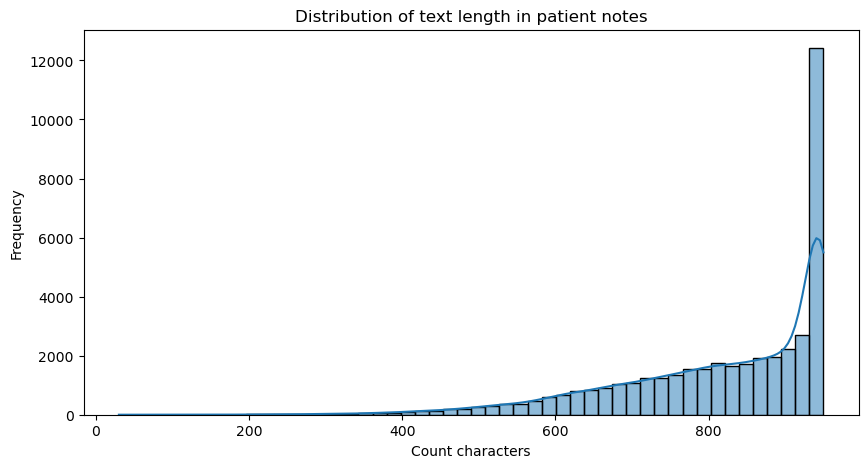

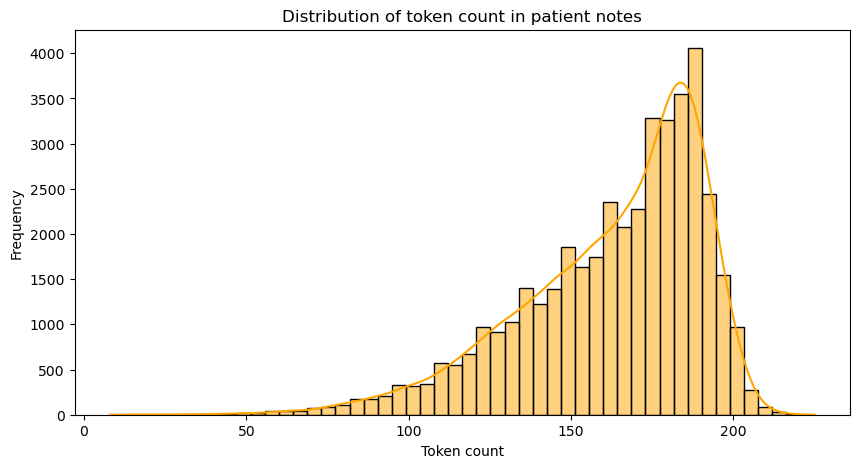

In [12]:
notes_df['note_length'] = notes_df['pn_history'].str.len()

# Plot histogram of note lengths
plt.figure(figsize=(10,5))
sns.histplot(notes_df['note_length'], bins=50, kde=True)
plt.title("Distribution of text length in patient notes")
plt.xlabel("Count characters")
plt.ylabel("Frequency")
plt.show()

notes_df['token_count'] = notes_df['pn_history'].apply(lambda x: len(word_tokenize(x)))

# Plot histogram of token counts
plt.figure(figsize=(10, 5))
sns.histplot(notes_df['token_count'], bins=50, kde=True, color='orange')
plt.title("Distribution of token count in patient notes")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

##### Span length: Number of characters per annotation

In [13]:
def get_span_lengths(location_str):
    if pd.isna(location_str) or not location_str.strip():
        return []
    try:
        # Remove brackets and single quotes from string
        cleaned = re.sub(r"[\[\]']", "", location_str)
        spans = []
        
        # Split by comma to separate features
        features = cleaned.split(',')
        
        for feature in features:
            feature = feature.strip()
            # Split by semicolon to get multiple spans within a feature
            span_parts = feature.split(';')
            
            for sp in span_parts:
                sp = sp.strip()
                # Split span into start and end positions
                start_end = sp.split()
                if len(start_end) == 2:
                    start, end = map(int, start_end)
                    spans.append((start, end))
        
        return spans
    except Exception as e:
        print(f"Error processing location '{location_str}': {e}")
        return []

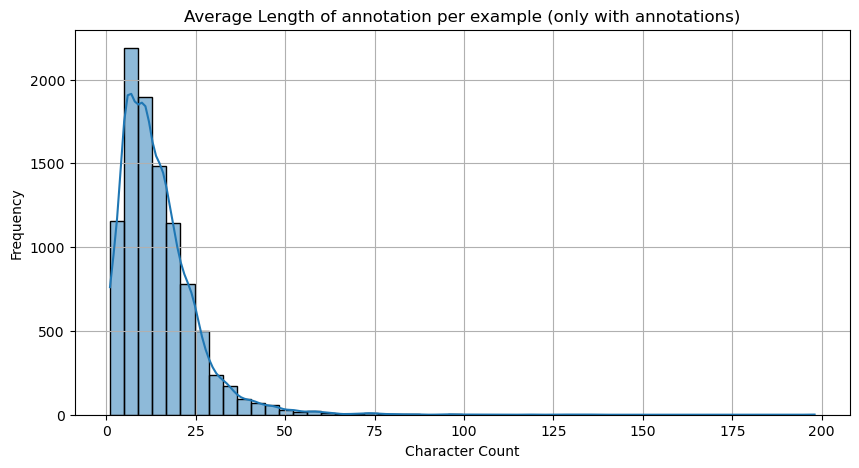

In [14]:
# Calculate span lengths for each example
merged_df['span_lengths'] = merged_df['location'].apply(
    lambda loc: [end - start for start, end in get_span_lengths(loc)]
)

# Compute average span length per example, if spans exist
merged_df['avg_span_length'] = merged_df['span_lengths'].apply(
    lambda lengths: sum(lengths) / len(lengths) if lengths else 0
)

# Filter out rows without any annotations (avg_span_length > 0)
filtered_df = merged_df[merged_df['avg_span_length'] > 0]

# Plot histogram of average annotation lengths
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(filtered_df['avg_span_length'], bins=50, kde=True)
plt.title("Average Length of annotation per example (only with annotations)")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

##### Top 10 Features

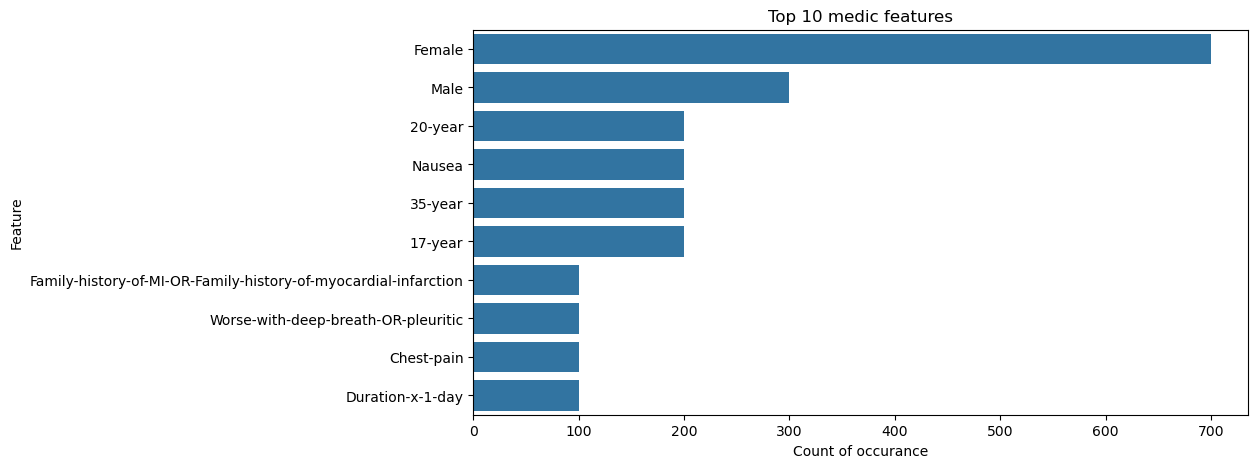

In [15]:
top_features = merged_df['feature_text'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 medic features")
plt.xlabel("Count of occurance")
plt.ylabel("Feature")
plt.show()

##### Check for missing values

In [16]:
print("\nMissing values:")
display(merged_df.isnull().sum())


Missing values:


id                 0
case_num           0
pn_num             0
feature_num        0
annotation         0
location           0
feature_text       0
pn_history         0
span_lengths       0
avg_span_length    0
dtype: int64

##### Check for duplicate values

In [17]:
print("\nAmount duplicates (train.csv):", train_df.duplicated().sum())


Amount duplicates (train.csv): 0


### Quick insights

##### Visualize a co-occurrence matrix of medical features in patient notes

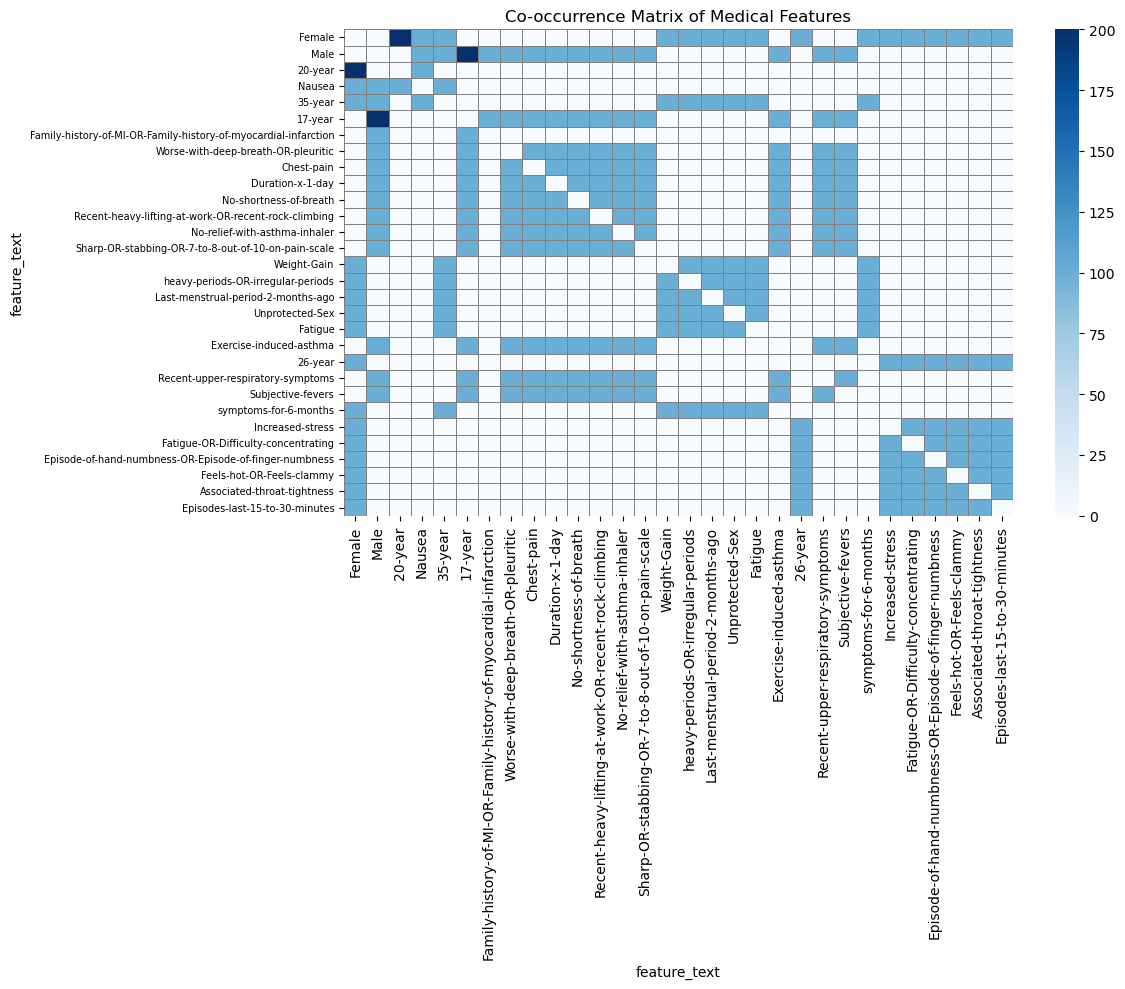

In [18]:
import numpy as np
### How often do different features occur simultaneously in a patient note ?

# Get all features per note
feature_sets = merged_df.groupby('pn_num')['feature_text'].apply(set)

# Build feature index
all_features = sorted(set(merged_df['feature_text']))
feature_to_idx = {f: i for i, f in enumerate(all_features)}

# Init matrix
co_matrix = np.zeros((len(all_features), len(all_features)), dtype=int)

# Count co-occurrences
for features in feature_sets:
    indices = [feature_to_idx[f] for f in features if f in feature_to_idx]
    for i in indices:
        for j in indices:
            if i != j:
                co_matrix[i, j] += 1

# Wrap in DataFrame
co_df = pd.DataFrame(co_matrix, index=all_features, columns=all_features)

# Focus on top 30 most frequent features
top_features = merged_df['feature_text'].value_counts().head(30).index
co_df_subset = co_df.loc[top_features, top_features]

# Plot it
plt.figure(figsize=(12, 10))
sns.heatmap(co_df_subset, cmap="Blues", linewidths=0.5, linecolor='gray')
plt.title("Co-occurrence Matrix of Medical Features")
plt.xticks(rotation=90)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()

##### TF-IDF: Terms from feature names

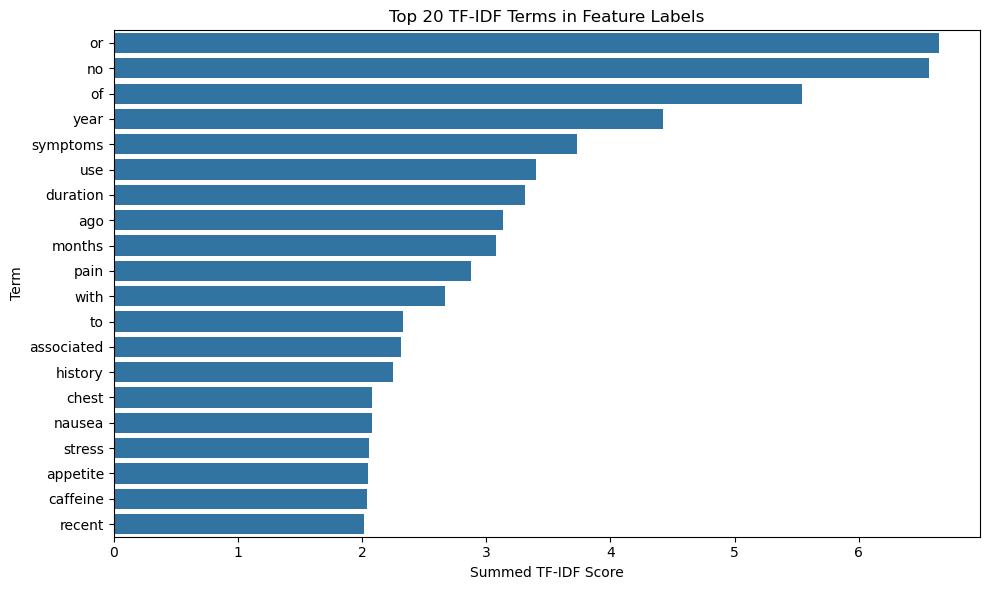

In [19]:
# Get unique feature texts (drop missing values)
feature_texts = merged_df['feature_text'].dropna().unique()

# Apply TF-IDF vectorizer on token level
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(feature_texts)

# Sum TF-IDF scores per token
tfidf_scores = X.sum(axis=0).A1  # convert to flat array
terms = vectorizer.get_feature_names_out()

# Build DataFrame with results
tfidf_df = pd.DataFrame({'term': terms, 'tfidf_sum': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

# Plot top 20 terms
plt.figure(figsize=(10, 6))
sns.barplot(data=tfidf_df.head(20), x='tfidf_sum', y='term')
plt.title("Top 20 TF-IDF Terms in Feature Labels")
plt.xlabel("Summed TF-IDF Score")
plt.ylabel("Term")
plt.tight_layout()
plt.show()

##### TF-IDF: Which words are typical for each feature label?

In [21]:
label_text_df = merged_df[['feature_text', 'pn_history']].dropna()

# Group all patient notes by feature and join into one large string per feature
grouped = label_text_df.groupby('feature_text')['pn_history'].apply(lambda texts: ' '.join(texts))

# Apply TF-IDF on the combined text per feature
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(grouped)

# Create a DataFrame: rows = features, columns = tokens
tfidf_df = pd.DataFrame(X.toarray(), index=grouped.index, columns=vectorizer.get_feature_names_out())

In [22]:
feature_list = sorted(merged_df['feature_text'].dropna().unique())

# Print feature list with indices
for idx, label in enumerate(feature_list):
    print(f"[{idx}] {label}")

[0] 1-day-duration-OR-2-days-duration
[1] 17-year
[2] 2-to-3-beers-a-week
[3] 20-year
[4] 26-year
[5] 35-year
[6] 44-year
[7] 45-year
[8] 67-year
[9] 8-to-10-hours-of-acute-pain
[10] Adderall-use
[11] Associated-SOB-OR-Associated-shortness-of-breath
[12] Associated-feeling-of-impending-doom
[13] Associated-nausea
[14] Associated-throat-tightness
[15] Auditory-hallucination-once
[16] Awakens-at-night
[17] Caffeine-use
[18] Chest-pain
[19] Chest-pressure
[20] Darker-bowel-movements
[21] Decreased-appetite
[22] Difficulty-falling-asleep
[23] Difficulty-with-sleep
[24] Diminished-appetite
[25] Diminished-energy-OR-feeling-drained
[26] Duration-x-1-day
[27] Early-wakening
[28] Epigastric-discomfort
[29] Episode-of-hand-numbness-OR-Episode-of-finger-numbness
[30] Episodes-last-15-to-30-minutes
[31] Episodes-of-heart-racing
[32] Exercise-induced-asthma
[33] FHx-of-PUD-OR-Family-history-of-peptic-ulcer-disease
[34] FHx-of-depression-OR-Family-history-of-depression
[35] Family-history-of-MI-OR-

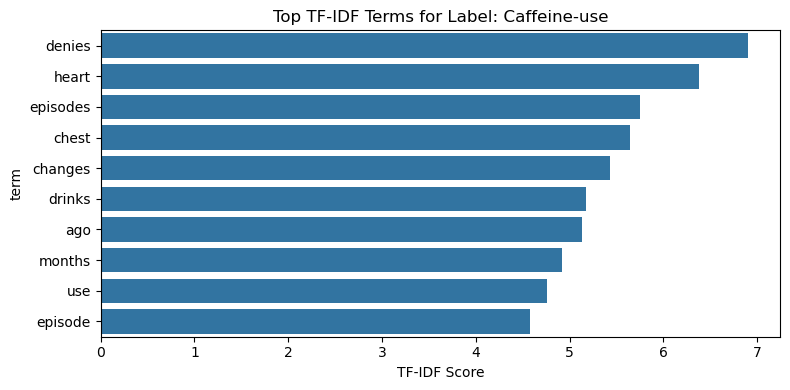

In [24]:
# Select label – use the exact text
label = feature_list[17]

# Get all patient notes for this label
texts = merged_df[merged_df['feature_text'] == label]['pn_history'].dropna().tolist()

# Skip if no notes are available
if not texts:
    print(f"No texts found for label '{label}'.")
else:
    # Apply TF-IDF on the relevant patient notes
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(texts)
    tfidf_scores = X.sum(axis=0).A1  # total TF-IDF score per term
    terms = vectorizer.get_feature_names_out()

    # Create DataFrame with TF-IDF values
    tfidf_df = pd.DataFrame({'term': terms, 'tfidf': tfidf_scores})
    top_terms = tfidf_df.sort_values(by='tfidf', ascending=False).head(10)

    # Plot top terms
    plt.figure(figsize=(8, 4))
    sns.barplot(x=top_terms['tfidf'], y=top_terms['term'])
    plt.title(f"Top TF-IDF Terms for Label: {label}")
    plt.xlabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()


##### Word Cloud: Feature label frequencies

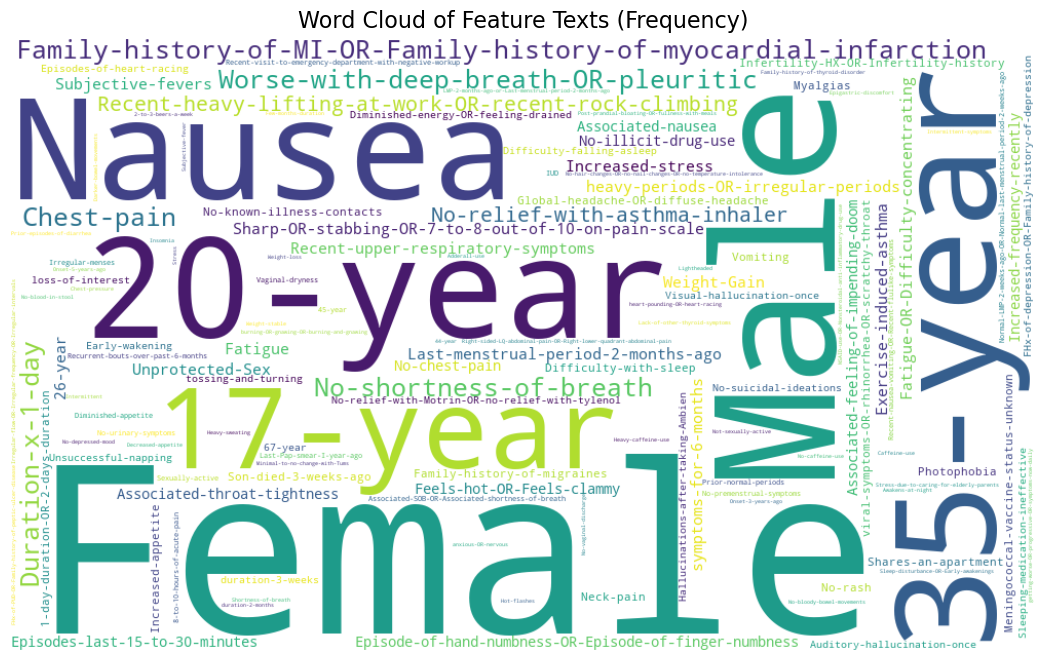

In [25]:
# Count how often each feature appears
feature_counts = merged_df['feature_text'].value_counts()

wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='viridis')
wordcloud.generate_from_frequencies(feature_counts)

# Display the WordCloud
plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Feature Texts (Frequency)", fontsize=16)
plt.show()

##### Word Cloud: All patient note texts

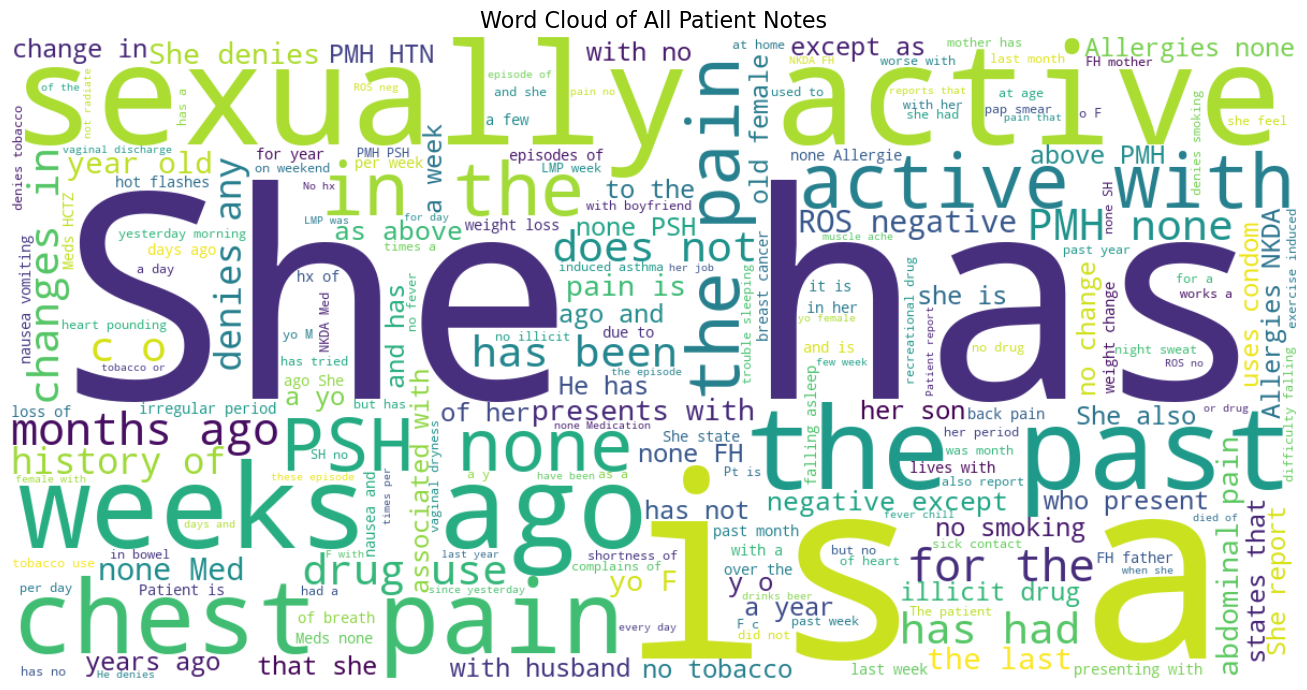

In [26]:
# Combine all patient note texts into a single string
text_corpus = ' '.join(merged_df['pn_history'].dropna())

wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color='white',
    stopwords='english',  # exclude common English stopwords
    max_words=200,
    colormap='viridis'
).generate(text_corpus)

# Display the Word Cloud
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Patient Notes", fontsize=16)
plt.tight_layout()
plt.show()
